In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime 

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

#Yahoo!Finance 模組
import yfinance as yf 

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [9]:
yf.pdr_override()
symbol = "BTC-USD"
# symbol = "DOGE-USD"
start =datetime.date(2014,9,17)
end = datetime.date.today()

# Read data
df = yf.download(symbol)
df_Indicators= yf.download(symbol)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [10]:
df_Indicators.shape

(3191, 6)

In [11]:
def SMA(close,n):   
    return close.rolling(window=n).mean()

def WMA(close, n):
    weights = np.array(range(1, n+1))
    sum_weights = np.sum(weights)

    res = close.rolling(window=n).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False)
    return res

def EMA(close, n):    
    res=close.ewm(span=n,min_periods=n).mean()
    return res

def RSI(close, n):
    # RSI
    change = close.diff(1)
    df["Gain"] = change.mask(change < 0, 0)
    df["Loss"] = abs(change.mask(change > 0, 0))
    df["AVG_Gain"] = df.Gain.rolling(n).mean()
    df["AVG_Loss"] = df.Loss.rolling(n).mean()
    df["RS"] = df["AVG_Gain"] / df["AVG_Loss"]
    df["RSI"] = 100 - (100 / (1 + df["RS"]))
    return df["RSI"]


def Stoch_RSI(close, n):
    #Stochastic RSI
    RSI=df["RSI"]
    LL_RSI = RSI.rolling(n).min()
    HH_RSI = RSI.rolling(n).max()         
    return (RSI - LL_RSI) / (HH_RSI - LL_RSI)

def BB(close, n):
    MA = pd.Series(close.rolling(n).mean())
    STD = pd.Series(close.rolling(n).std())
    bb1 = MA + 2 * STD
    df["Upper Bollinger Band"] = pd.Series(bb1)
    bb2 = MA - 2 * STD
    df["Lower Bollinger Band"] = pd.Series(bb2)
    return df["Upper Bollinger Band"],df["Lower Bollinger Band"]

def MACD(close):
    df['EMA12'] = close.ewm(span=12, adjust=False).mean() 
    df['EMA26'] = close.ewm(span=26, adjust= False).mean() 
    return df['EMA12'] - df['EMA26'] 


# 指標副程式(資料,天數)
df_Indicators['SMA_7']=SMA(df['Adj Close'],7)
df_Indicators['SMA_14']=SMA(df['Adj Close'],14)

df_Indicators['EMA_7']=EMA(df['Adj Close'],7)
df_Indicators['EMA_14']=EMA(df['Adj Close'],14)

df_Indicators['RSI']=RSI(df['Adj Close'],14)


df_Indicators['Stoch_RSI']=Stoch_RSI(df['Adj Close'],14)

df_Indicators['Upper_BB']=BB(df['Adj Close'],20)[0]
df_Indicators['Lower_BB']=BB(df['Adj Close'],20)[1]

df_Indicators['MACD']=MACD(df['Adj Close'])
df_Indicators= df_Indicators.dropna()
df_Indicators.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_7,SMA_14,EMA_7,EMA_14,RSI,Stoch_RSI,Upper_BB,Lower_BB,MACD
Date,,,,,,,,,,,,,,,
2014-10-14,391.691986,411.697998,391.324005,400.869995,400.869995,38491500,373.094291,360.392931,376.986690,371.799589,54.529605,0.991932,422.829855,317.231348,-10.737706
2014-10-15,400.954987,402.226990,388.765991,394.773010,394.773010,25267100,379.070435,361.189933,381.434329,374.911777,53.565092,0.965996,419.691379,318.689724,-8.196223
2014-10-16,394.518005,398.807007,373.070007,382.556000,382.556000,26990000,381.574720,361.724505,381.714797,375.945126,52.336359,0.932954,416.279522,319.914682,-7.086205
2014-10-17,382.756012,385.477997,375.389008,383.757996,383.757996,13600700,384.745575,363.456362,382.225665,376.999326,58.314477,1.000000,413.813751,320.804254,-6.039892
2014-10-18,383.976013,395.157990,378.971008,391.441986,391.441986,11416800,388.908857,367.926076,384.529977,378.944982,75.469711,1.000000,415.589314,320.454790,-4.538333


In [12]:
df_Indicators.shape

(3164, 15)

In [25]:
#二值化收盤價，昨天比今天高就是跌，就為False
# UpDown=[True]
# for i in range(1,len(df['Close'])):
#     if df['Close'][i]>df['Close'][i-1]:
#         UpDown.append(True)
#     else:
#         UpDown.append(False)
# df['UpDown'] = UpDown

In [13]:
n = len(df)
train_df = df_Indicators[0:int(n*0.7)]
val_df = df_Indicators[int(n*0.7):int(n*0.9)]
test_df = df_Indicators[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((2233, 15), (638, 15), (293, 15))

In [14]:
#將值縮限在0~1之間，加速訓練時間
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [24]:
train_df.to_csv('data/train.csv')
val_df.to_csv('data/val.csv')
test_df.to_csv('data/test.csv')

In [15]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [16]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [17]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [18]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['Adj Close'])

In [27]:
ms_cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)
print(f"驗證集的MSE {ms_val_performance['CNN'][1]}")
print(f"測試集的MSE {ms_performance['CNN'][1]}")


Epoch 1/1000
70/70 [==============================] - 4s 15ms/step - loss: 0.0234 - mean_absolute_error: 0.1002 - val_loss: 1.9072 - val_mean_absolute_error: 1.2558
Epoch 2/1000
70/70 [==============================] - 1s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0432 - val_loss: 1.3191 - val_mean_absolute_error: 1.0034
Epoch 3/1000
70/70 [==============================] - 1s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0212 - val_loss: 1.1311 - val_mean_absolute_error: 0.9178
Epoch 4/1000
70/70 [==============================] - 1s 7ms/step - loss: 6.4175e-04 - mean_absolute_error: 0.0160 - val_loss: 1.0574 - val_mean_absolute_error: 0.8799
Epoch 5/1000
70/70 [==============================] - 1s 7ms/step - loss: 5.8553e-04 - mean_absolute_error: 0.0151 - val_loss: 1.0024 - val_mean_absolute_error: 0.8516
Epoch 6/1000
70/70 [==============================] - 1s 7ms/step - loss: 5.1625e-04 - mean_absolute_error: 0.0141 - val_loss: 1.0131 - val_mean_absolute_error: 0.8592
Epo

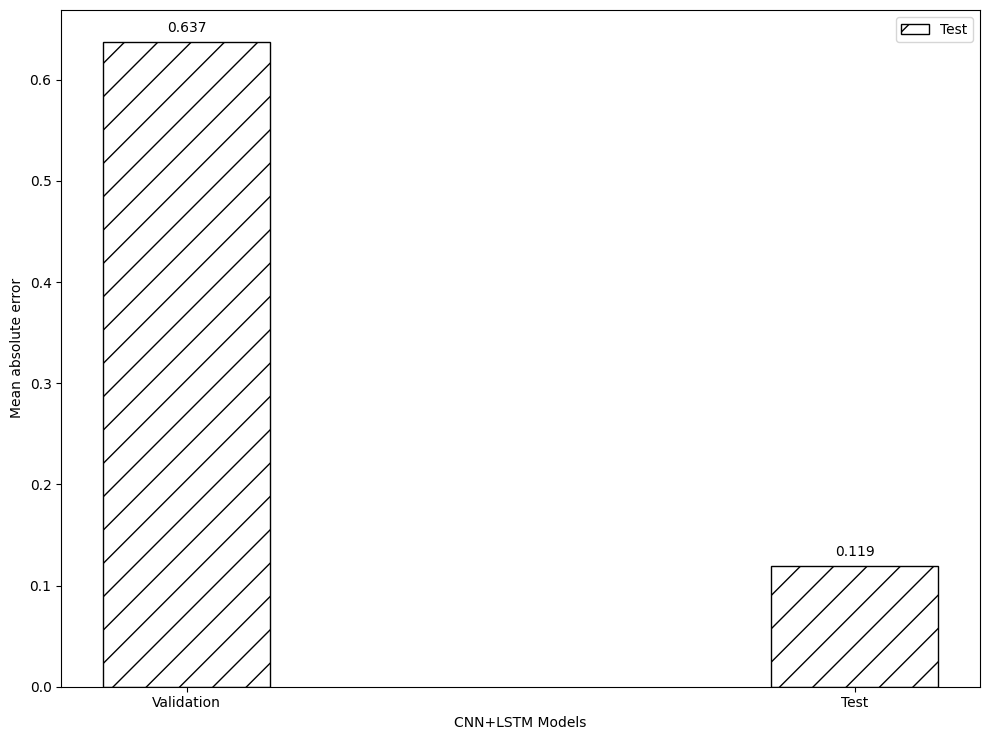

In [22]:
ms_mae_test=[ms_val_performance['CNN'][1],ms_performance['CNN'][1]]

x = np.arange(len(ms_mae_test))
labels = [ 'Validation','Test']

plt.bar(x,ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')

for i in x:
    plt.text(x=i, y=ms_mae_test[i]+ 0.01, s=str(round(ms_mae_test[i], 3)), ha='center')



plt.xlabel('CNN+LSTM Models')
plt.ylabel('Mean absolute error')
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('figure/CNN+LSTM Models.png', dpi=300)